In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams.update({
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.linewidth': 0.5,
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'xtick.minor.size': 1,
    'ytick.minor.size': 1,
    'xtick.labelsize': 8,       # 8 point font size
    'ytick.labelsize': 8,       # 8 point font size
    'grid.alpha': 0.3,
})

## Eliciting datasets and using date/time columns as index for Time Series Analysis.

In [3]:
Johnson = pd.read_csv('./Data/jj.csv')
Johnson['date'] = pd.to_datetime(Johnson['date'])
Johnson.set_index('date', inplace=True)
Johnson.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [4]:
Amazon = pd.read_csv('./Data/AMZN.csv')
Amazon['Date'] = pd.to_datetime(Amazon['Date'])
Amazon.set_index('Date', inplace=True)
Amazon.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


Plotting target variables for both datasets.

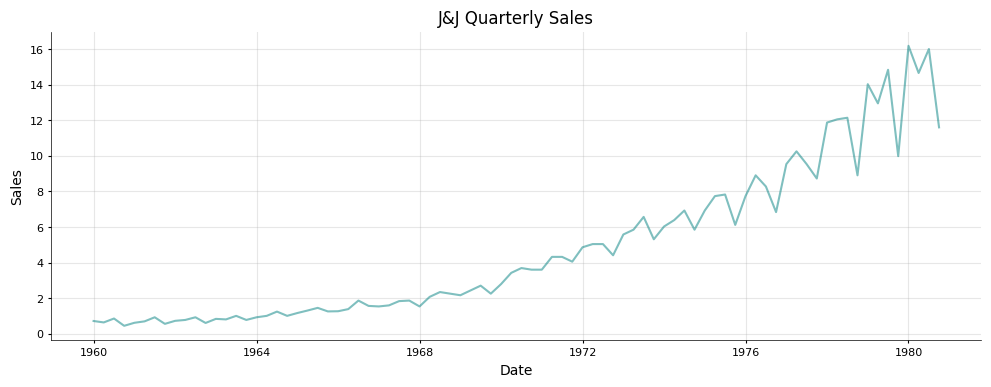

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(Johnson['data'], color='teal', alpha=0.5)
plt.title('J&J Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


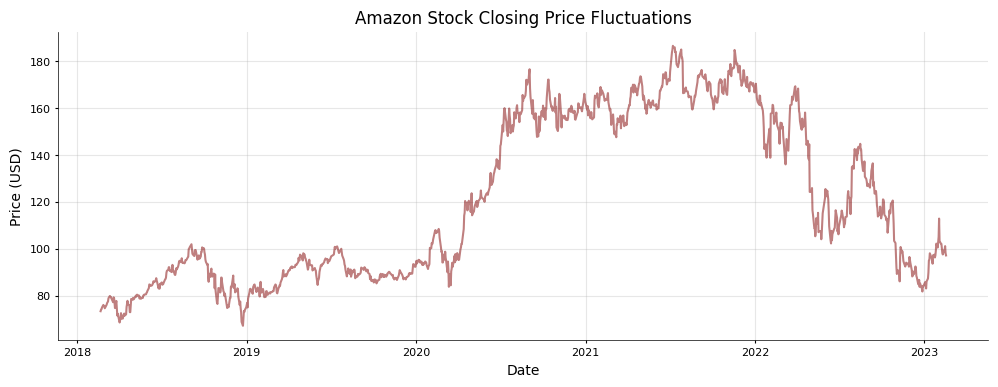

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(Amazon['Close'], color='Maroon', alpha=0.5)
plt.title('Amazon Stock Closing Price Fluctuations')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

## Investigating properties of the datasets.

#### Johnson & Johnson

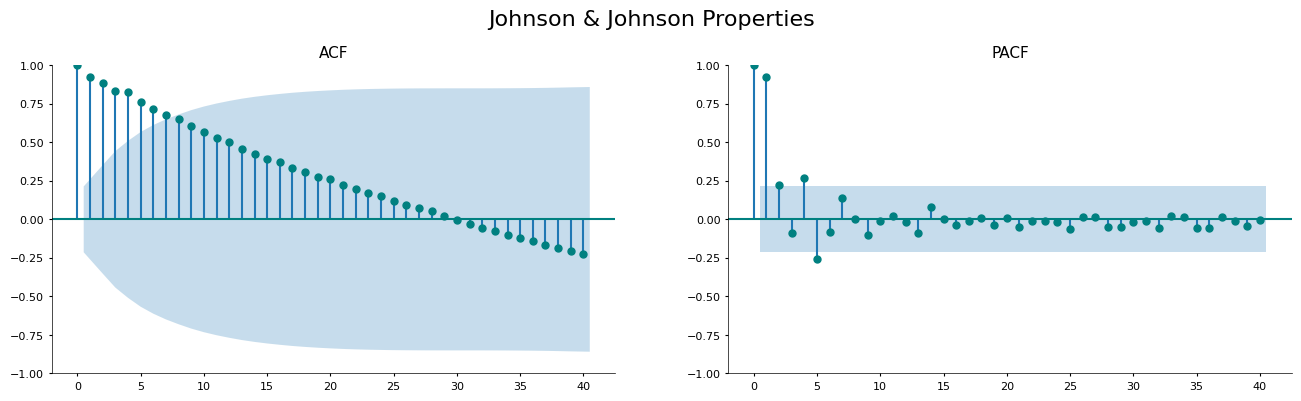

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(Johnson['data'], lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(Johnson['data'], lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Johnson & Johnson Properties', fontsize=16, y=1.02)
plt.show()

In [8]:
# Defining a function for ADF Testing.
def AdfTester(series, name=''):
    """
    Parameters:
    series : Time series data.
    name : to print a name of the set undergoing ADF.
    """

    AdfResult = adfuller(series.squeeze())

    print(f'---ADF Test Results for {name}---')
    print(f'ADF Statistic: {AdfResult[0]: .3f}')
    print(f'P-Value: {AdfResult[1]: .3f}')

    for key, value in AdfResult[4].items():
        print(f'Critical Value ({key}): {value: .3f}')

In [9]:
AdfTester(Johnson['data'], 'Johnson & Johnson Data')

---ADF Test Results for Johnson & Johnson Data---
ADF Statistic:  2.742
P-Value:  1.000
Critical Value (1%): -3.525
Critical Value (5%): -2.903
Critical Value (10%): -2.589


Non-stationary is observed in data as the 5% critical is less than ADF Statistic with a P-Value greater that 0.05, applying log & first order differencing.

In [10]:
JohnsonLog = np.log(Johnson + 1e-10) # Adding a small constant to avoid log(0)

In [11]:
JohnsonLogFODiff = JohnsonLog.diff().dropna()
AdfTester(JohnsonLogFODiff.squeeze(), 'J&J with First Order Differencing')

---ADF Test Results for J&J with First Order Differencing---
ADF Statistic: -4.317
P-Value:  0.000
Critical Value (1%): -3.518
Critical Value (5%): -2.900
Critical Value (10%): -2.587


Stationarity acquired after 1st order differencing, visualized as below.

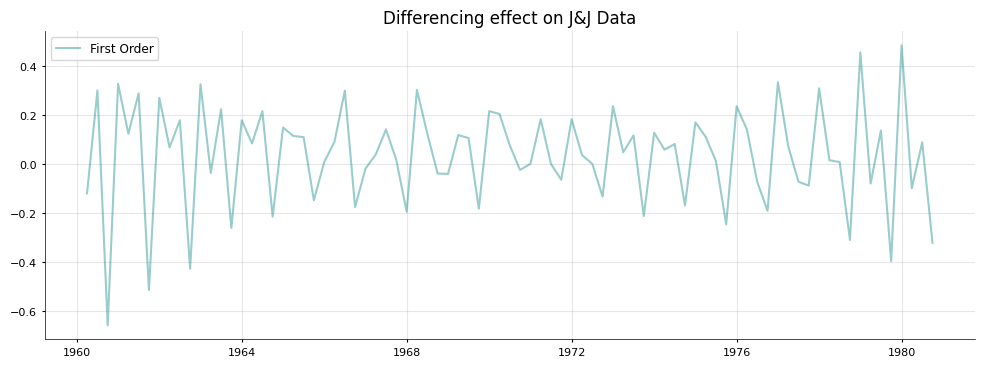

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(JohnsonLogFODiff['data'], label='First Order', alpha=0.4, color='Teal')
plt.title('Differencing effect on J&J Data')
plt.legend(fontsize=8.75)
plt.grid(True)
plt.show()

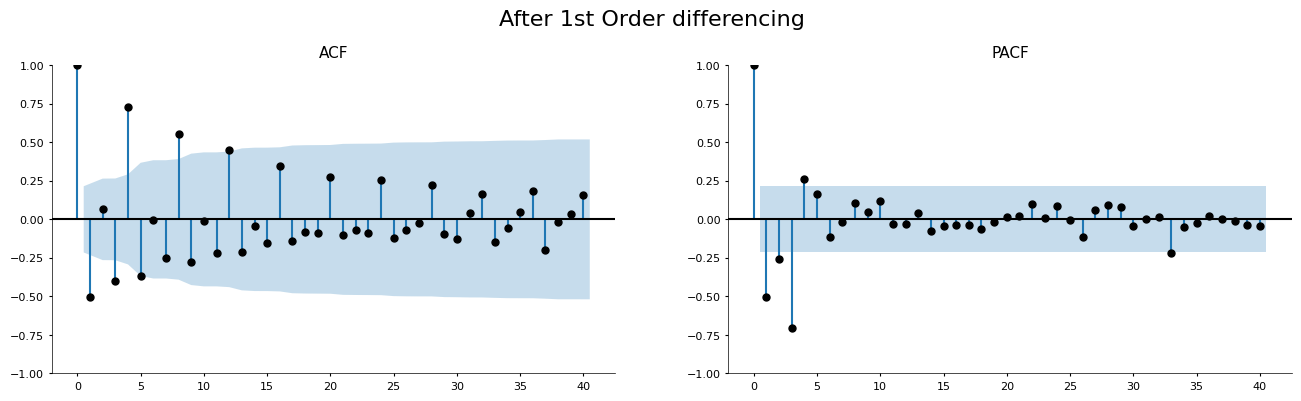

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(JohnsonLogFODiff['data'], lags=40, ax=ax[0], color='Black')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(JohnsonLogFODiff['data'], lags=40, ax=ax[1], color='Black')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('After 1st Order differencing', fontsize=16, y=1.02)
plt.show()

Applying boxcox to compare Log & Boxcox Transformation in handling non-stationarity.

In [14]:
JohnsonBC, lambda_ = boxcox(Johnson['data'] + 1 - Johnson['data'].min())

In [15]:
JohnsonBCFODiff = np.diff(JohnsonBC)
AdfTester(JohnsonBCFODiff.squeeze(), 'J&J with First Order Differencing')

---ADF Test Results for J&J with First Order Differencing---
ADF Statistic: -2.889
P-Value:  0.047
Critical Value (1%): -3.521
Critical Value (5%): -2.901
Critical Value (10%): -2.588


Stationarity Achieved after 1st order differencing, visualized as below.

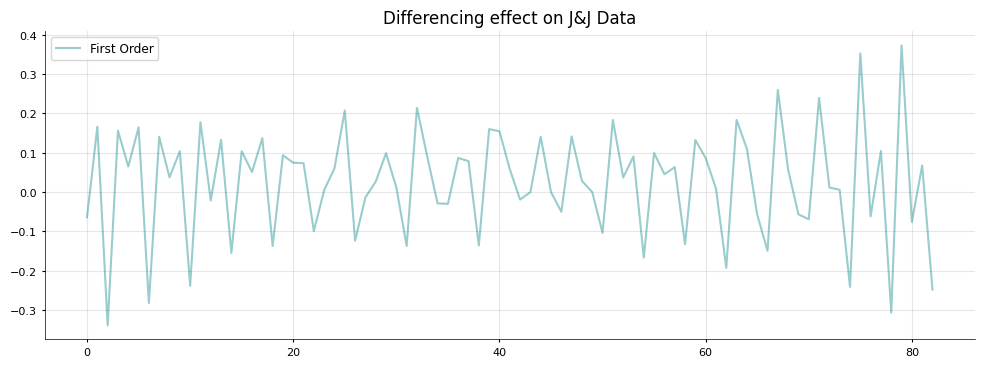

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(JohnsonBCFODiff, label='First Order', alpha=0.4, color='Teal')
plt.title('Differencing effect on J&J Data')
plt.legend(fontsize=8.75)
plt.grid(True)
plt.show()

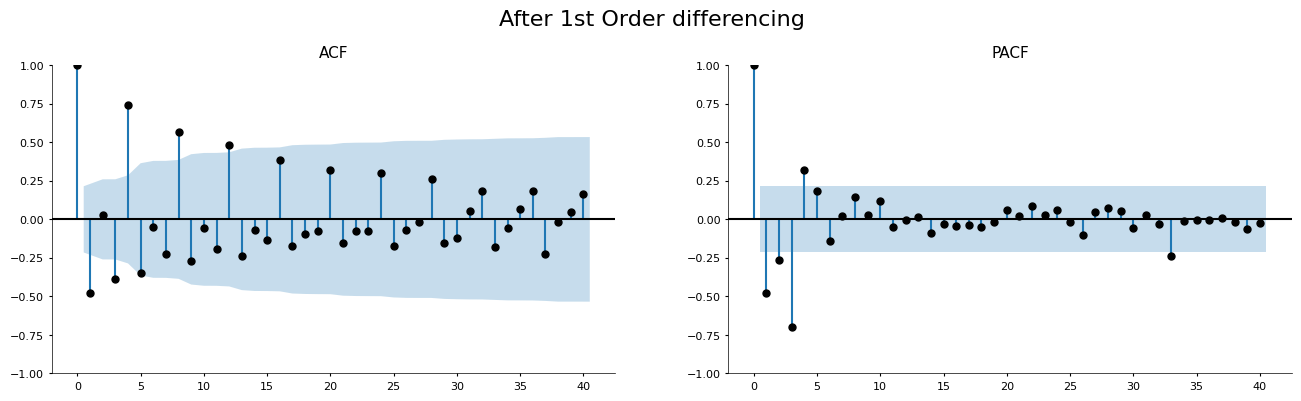

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(JohnsonBCFODiff, lags=40, ax=ax[0], color='Black')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(JohnsonBCFODiff, lags=40, ax=ax[1], color='Black')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('After 1st Order differencing', fontsize=16, y=1.02)
plt.show()

Log Transformed data acquires stationarity after first order differencing so we'll move forward with that.

#### Amazon

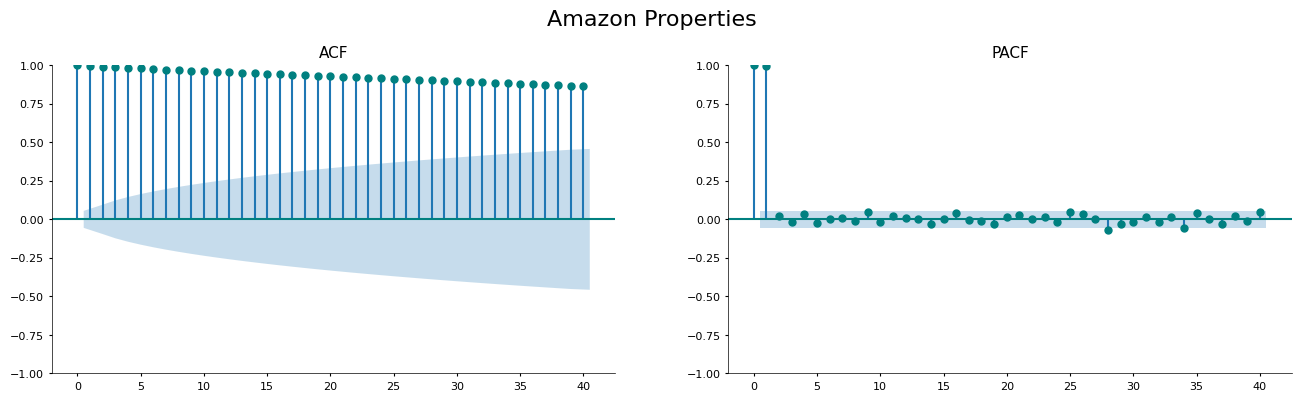

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(Amazon['Close'], lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(Amazon['Close'], lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Amazon Properties', fontsize=16, y=1.02)
plt.show()

In [19]:
AdfTester(Amazon['Close'], 'Amazon Data')

---ADF Test Results for Amazon Data---
ADF Statistic: -1.658
P-Value:  0.453
Critical Value (1%): -3.436
Critical Value (5%): -2.864
Critical Value (10%): -2.568


Differencing is required as P-Value is higher than 0.05 & critical value at 5% (-2.864) is also less than ADF Statistic (-1.658). 

In [20]:
AmazonLog = np.log(Amazon['Close'] + 1e-10) # Adding a small constant to avoid log(0)

In [21]:
AmazonFODiff = AmazonLog.diff().dropna()
AdfTester(AmazonFODiff, 'Amazon (After 1st Order Difference)')

---ADF Test Results for Amazon (After 1st Order Difference)---
ADF Statistic: -36.640
P-Value:  0.000
Critical Value (1%): -3.436
Critical Value (5%): -2.864
Critical Value (10%): -2.568


Stationarity acquired after first order differencing, Visualized as below.

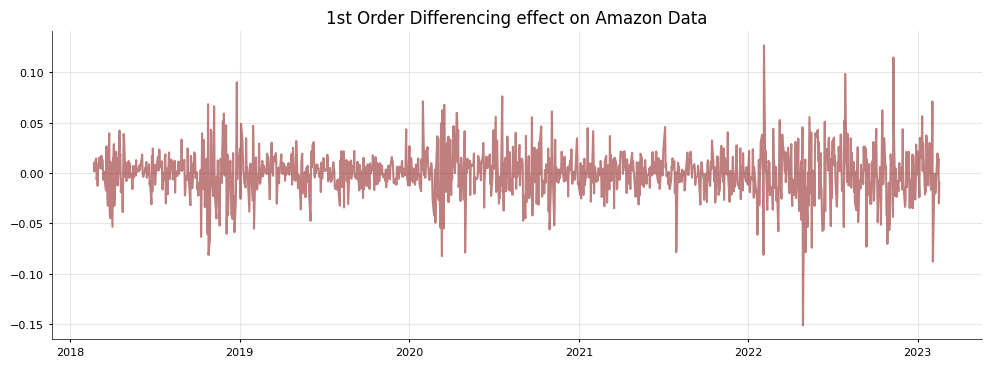

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(AmazonFODiff, label='First Order', alpha=0.5, color='Maroon')
plt.title('1st Order Differencing effect on Amazon Data')
plt.grid(True)
plt.show()

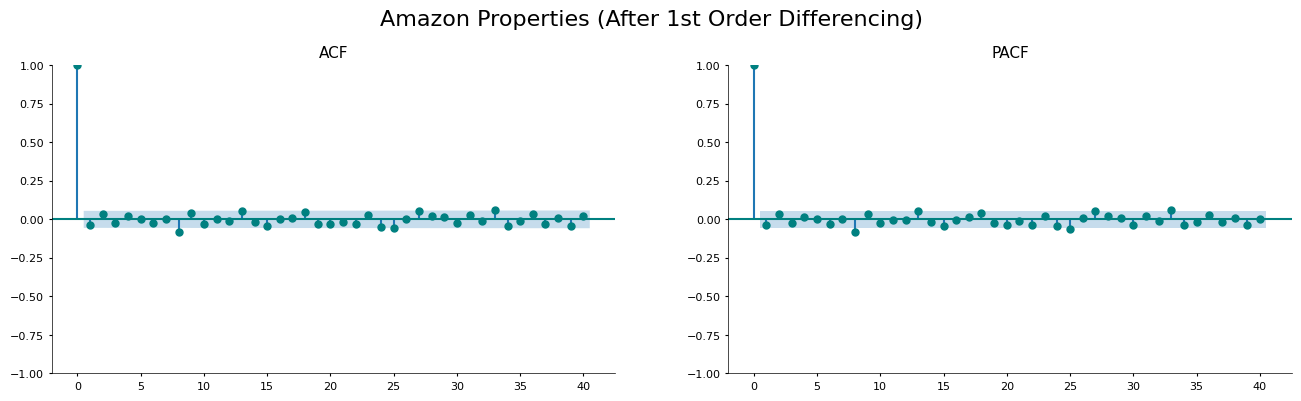

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(AmazonFODiff, lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(AmazonFODiff, lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Amazon Properties (After 1st Order Differencing)', fontsize=16, y=1.02)
plt.show()

Copying stationary datasets.

In [24]:
Amazon = pd.DataFrame(AmazonFODiff)
Johnson = pd.DataFrame(JohnsonLogFODiff)

## Training ARMA models with transformed data.

#### Manual Approach

In [25]:
from tqdm import tqdm
def ManArimaBP(TrainData, MaxP=12, MaxD=1, MaxQ=12):
    """
    Grid search over p, d & q to find the best fit with lowest AIC.
    """

    BestAIC = np.inf
    BestOrder = None
    Results = []

    # Generating all possible combinations for p,d & q.
    pdq = list(product(range(0, MaxP+1), 
                       range(0,MaxD+1), 
                       range(0,MaxQ+1)))
    
    # Removing (0, 0, 0) corresponding to white noise.
    pdq = [order for order in pdq if order != (0, 0, 0)]

    with warnings.catch_warnings():
        for order in tqdm(pdq):
            try:
                Model = ARIMA(TrainData, order=order)
                ModelFit = Model.fit()
                Aic = ModelFit.aic
                Results.append({'Order': order,'AIC': Aic})
                if Aic < BestAIC:
                    BestAIC = Aic
                    BestOrder = order
            except:
                continue # To skip combinations that cause invalidity.
    
    ResultantDF = pd.DataFrame(Results).sort_values('AIC')
    return BestOrder, BestAIC, ResultantDF

BestOrder, BestAIC, ResultDF = ManArimaBP(Johnson)
print(f'Best ARIMA Order: {BestOrder} | AIC: {BestAIC}' )

100%|██████████| 337/337 [03:57<00:00,  1.42it/s]

Best ARIMA Order: (3, 0, 2) | AIC: -151.14960398517218


#### Automated Approach

Unable to complete milestone, dependency error as below.

from pmdarima import auto_arima

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[27], line 1
----> 1 from pmdarima import auto_arima

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\__init__.py:52
     49 from . import __check_build
     51 # Stuff we want at top-level
---> 52 from .arima import auto_arima, ARIMA, AutoARIMA, StepwiseContext, decompose
     53 from .utils import acf, autocorr_plot, c, pacf, plot_acf, plot_pacf, \
     54     tsdisplay
     55 from .utils._show_versions import show_versions

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\__init__.py:5
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
----> 5 from .approx import *
      6 from .arima import *
      7 from .auto import *

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\approx.py:9
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
      4 #
      5 # R approx function
      7 import numpy as np
----> 9 from ..utils.array import c, check_endog
     10 from ..utils import get_callable
     11 from ..compat.numpy import DTYPE

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\__init__.py:5
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
----> 5 from .array import *
      6 from .metaestimators import *
      7 from .visualization import *

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\array.py:13
     10 import pandas as pd
     12 from ..compat import DTYPE
---> 13 from ._array import C_intgrt_vec
     15 __all__ = [
     16     'as_series',
     17     'c',
   (...)
     22     'is_iterable'
     23 ]
     26 def as_series(x, **kwargs):

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\_array.pyx:1, in init pmdarima.utils._array()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Hypothetical methodology implemented as below.

def AutoArimaBP(TrainData, seasonal=False, MaxP=12, MaxD=1, MaxQ=8):
    """
    Automatically find best ARIMA model using pmdarima.
    """

    Model = auto_arima(
        TrainData,
        seasonal=seasonal,
        max_p=MaxP,
        max_d=MaxD,
        max_q=MaxQ,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic',
        trace=True
    )

    return Model

AutoModel = AutoArimaBP(Johnson, seasonal=False)
print(AutoModel.summary())

Using best parameters (available) to train model for forecasting.

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   83
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  82.575
Date:                Thu, 10 Apr 2025   AIC                           -151.150
Time:                        20:22:11   BIC                           -134.218
Sample:                             0   HQIC                          -144.347
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.004      9.030      0.000       0.030       0.047
ar.L1         -0.9945      0.051    -19.575      0.000      -1.094      -0.895
ar.L2         -0.9743      0.060    -16.252      0.0

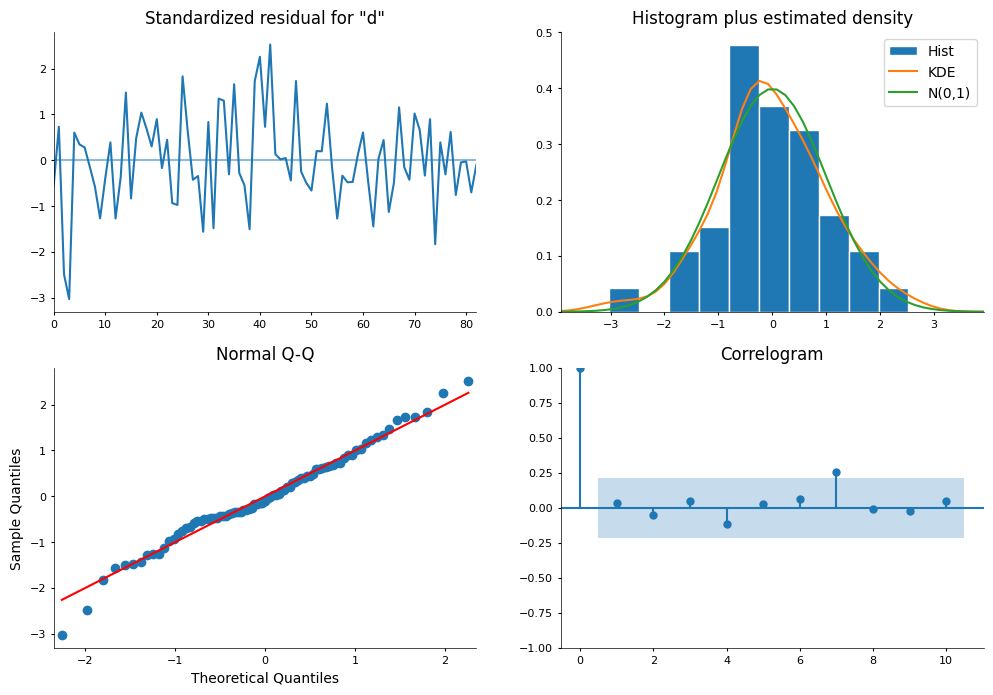

In [34]:
ArimaModel = ARIMA(Johnson, order=(3, 0, 2))
ArimaFit = ArimaModel.fit()

print(ArimaFit.summary())

ArimaFit.plot_diagnostics(figsize=(12, 8))
plt.show()